For this exam, use the included data file, `factor_model_data_with_momentum.xls`.

 - The first tab contains the factors. Note that you need to compute,
 
 $$
 \tilde r^m = r^m - r^f.
 $$
 
 - The second tab contains monthly excess returns on 30 test portfolios, $\tilde r^i_t$, corresponding to equities grouped by industries. 
 
We won't be using the other tabs in this exam.

# Problem 1 (10 pts)

For the 30 industry portfolios in the second tab of the data, compute the means and standard deviations of each. Be sure to annualize them. Plot the means on the y-axis and the standard deviations on the x-axis. In your report, only include the final plot.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
path = 'factor_model_data_with_momentum.xls'
df_factor = pd.read_excel(path, sheet_name='Factor Data').set_index('Date')
df_factor['rx_mkt'] = df_factor['r_mkt'] - df_factor['r_f']

temp = pd.read_excel(path, sheet_name='Industry Portfolios').set_index('Date')
temp.columns = temp.columns.str.strip()
ind_portfolios_names = temp.columns
df_industries = df_factor.join(temp)

temp = pd.read_excel(path, sheet_name='Momentum Deciles').set_index('Date')
temp.columns = temp.columns.str.strip()
momentum_portfolio_names = temp.columns
df_momentum = df_factor.join(temp)

temp = pd.read_excel(path, sheet_name='Momentum by Size').set_index('Date')
temp.columns = temp.columns.str.strip()
mom_size_portfolio_names = temp.columns
df_mom_size = df_factor.join(temp)

del temp

In [3]:
columns = df_industries[ind_portfolios_names].columns
reg_stats = pd.DataFrame(index=columns, 
                         columns=['beta', 'mean', 'std', 'treynor_ratio', 'sharpe_ratio'],
                         dtype=np.float)

for col in columns:
    lhs = df_industries[col]
    rhs = sm.add_constant(df_industries['rx_mkt'])
    res = sm.OLS(lhs, rhs, missing='drop').fit()
    reg_stats.loc[col, 'alpha'] = res.params['const']
    reg_stats.loc[col, 'beta'] = res.params['rx_mkt']
    reg_stats.loc[col, 'mean'] = df_industries[col].mean() * 12
    reg_stats.loc[col, 'std'] = df_industries[col].std() * np.sqrt(12)
    reg_stats.loc[col, 'skewness'] = df_industries[col].skew()
    reg_stats.loc[col, 'std_residuals'] = res.resid.std()
    reg_stats.loc[col, 'treynor_ratio'] = reg_stats.loc[col, 'mean'] / reg_stats.loc[col, 'beta']
    reg_stats.loc[col, 'sharpe_ratio'] = reg_stats.loc[col, 'mean'] / reg_stats.loc[col, 'beta']

C:\Users\Jeremy\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


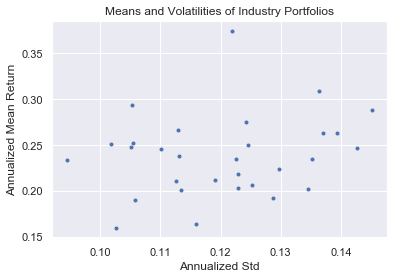

In [4]:
plt.plot(reg_stats['mean'], reg_stats['std'], '.')
plt.ylabel('Annualized Mean Return')
plt.xlabel('Annualized Std')
plt.title('Means and Volatilities of Industry Portfolios');

# Problem 2: (10 pts)

Run single factor time series regressions for each of the 30 portfolios, using
excess market returns as the single factor. Compute the Treynor ratio for each
industry portfolio. Report the 5 portfolios with the highest Treynor ratio
and the 5 portfolios with the lowest Treynor ratio. 
Additionally, report the average Treynor
ratio among these portfolios.

In [5]:
reg_stats['treynor_ratio'].nlargest(5)

Smoke   0.2176
Servs   0.1799
Food    0.1596
Telcm   0.1572
Hlth    0.1553
Name: treynor_ratio, dtype: float64

In [6]:
reg_stats['treynor_ratio'].nsmallest(5)

Steel   0.0781
Other   0.0899
Whlsl   0.0945
Coal    0.0956
Books   0.0959
Name: treynor_ratio, dtype: float64

In [7]:
print(f"Average Treynor ratio is {reg_stats['treynor_ratio'].mean()}")

Average Treynor ratio is 0.12370213082165933


# Problem 3: (10 pts) Plot MV efficient frontier

Suppose that you can only invest in the 30 industry portfolios listed in the second tab. You cannot invest in a risky security. Use the appropriate formula from the notes to construct and plot the mean-variance efficient frontier. Your plot should resemble the one shown below. It should have the axes appropriately labelled. (Though, you do NOT need to match the styling.) Be sure to annualize all statistics.

![mean_variance_efficient_frontier](mean_variance_efficient_frontier.png)


### Solution

The relevant formulas from the notes are these.

$$
\omega^* = \delta \omega^\text{t} + (1-\delta) \omega^\text{v}
$$

$$
\omega^\text{t} \equiv \left( \frac{1}{\mathbf1 \mathbf \Sigma^{-1} \mathbf \mu}
\right) \mathbf \Sigma^{-1} \mathbf \mu
$$

$$
\omega^\text{v} \equiv \left( \frac{1}{\mathbf 1 \mathbf \Sigma^{-1} \mathbf 1}
\right) \mathbf \Sigma^{-1} \mathbf \mu
$$

The mean-variance efficient portfolios are those $\omega^*$ with $\delta \in [0,\infty)$.

In [8]:
rets = df_industries[ind_portfolios_names]
mu = rets.mean()
Sigma = rets.cov()

N = 30
Sigma_inv = np.linalg.inv(Sigma)
omega_tangecy = Sigma_inv @ mu / (np.ones(N) @ Sigma_inv @ mu)
omega_v = Sigma_inv @ mu / (np.ones(N) @ Sigma_inv @ np.ones(N))

In [9]:
num_points = 100
means = np.zeros(num_points)
stds = np.zeros(num_points)

for i, delta in enumerate(np.linspace(0, 1.3, num_points)):
    omega_star = delta * omega_tangecy + (1-delta) * omega_v
    mean = 12 * omega_star @ mu
    std = np.sqrt(12) * omega_star @ Sigma @ omega_star
    means[i] = mean
    stds[i] = std

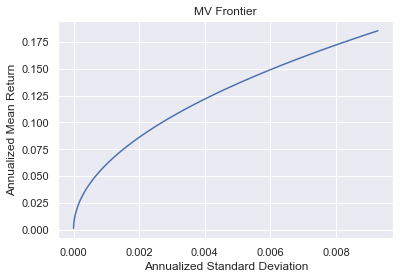

In [10]:
plt.plot(stds, means)
plt.title("MV Frontier")
plt.ylabel("Annualized Mean Return")
plt.xlabel("Annualized Standard Deviation");
plt.savefig('mean_variance_efficient_frontier.png', dpi=300)

# Problem 4: 

## (a) (5 pts)

Which industry has the highest skewness? List only the top 5 industries. List them in order from highest to lowest. Report the industry label and the skewness statistic associated with each. Don't scale skewness.

In [11]:
reg_stats.skewness.nlargest(5)

Coal    2.0748
Beer    1.7632
Steel   1.2614
Autos   1.1448
Servs   1.1407
Name: skewness, dtype: float64

## (b) (5 pts)

Compute the 10\% level, 1-month Value-at-Risk of the Oil industry portfolio in terms of returns. Do NOT annualize the return statistic here. Give in terms of monthly returns.

In [12]:
oil = df_industries['Oil']
VaR = oil.quantile(0.10)
VaR

-0.058089999999999996

## (c) (5 pts)

Compute the expected shortfall at the 1-month, 10\% level of the Oil industry portfolio. Again, do this in terms of returns. (The mean of returns that are less than or equal to the 10th percentile.)

In [13]:
ES = oil[oil <= VaR].mean() 
ES

-0.09826517857142858

## (d) (5 pts)

Regress the oil industry portfolio on the excess returns of the market.
Compute the information ratio resulting from this regression.

In [14]:
IR_list = reg_stats['alpha'] / reg_stats['std_residuals']

In [15]:
IR_list['Oil']

0.16565374551814852